# ‘RE’ward ‘I’ncrement ‘N’on-negative ‘F’actor times ‘O’ffset ‘R’einforcement times ‘C’haracteristic ‘E’ligibility (REINFORCE) v2 with chatGPT

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import flappy_bird_gymnasium
import matplotlib.pyplot as plt
import random
import gymnasium as gym

## Defining Policy Network

In [3]:
# --- Hyperparameters ---
LEARNING_RATE = 1e-3
GAMMA = 0.99
NUM_EPISODES = 10000

class Policy_Network(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy_Network, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)


def choose_action(policy_net, state):
    state = torch.tensor(state, dtype=torch.float32)
    probs = policy_net(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)


def compute_returns(rewards, gamma=GAMMA):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return torch.tensor(returns, dtype=torch.float32)


def train(env):
    policy_net = Policy_Network(state_dim=12, action_dim=2)
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

    episode_rewards = []

    for episode in range(NUM_EPISODES):
        state = env.reset()[0]
        log_probs = []
        rewards = []
        total_reward = 0

        done = False
        while not done:
            action, log_prob = choose_action(policy_net, state)

            next_state, reward, done, _, info = env.step(action)

            log_probs.append(log_prob)
            rewards.append(reward)
            total_reward += reward
            state = next_state

        # Compute returns and normalize
        returns = compute_returns(rewards)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Compute policy loss
        policy_loss = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_loss.append(-log_prob * Gt)
        loss = torch.stack(policy_loss).sum()

        # Update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        episode_rewards.append(total_reward)

        if episode % 100 == 0:
            avg = np.mean(episode_rewards[-10:])
            print(f"Episode {episode}, Avg reward: {avg:.2f}")

    # Save model after training
    torch.save(policy_net.state_dict(), "saved_policies/REINFORCE_policy_net.pth")


    # Plot rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Training')
    plt.show()

## Training

Episode 0, Avg reward: -8.10
Episode 10, Avg reward: -7.32
Episode 20, Avg reward: -7.14
Episode 30, Avg reward: -7.80
Episode 40, Avg reward: -8.40
Episode 50, Avg reward: -7.80
Episode 60, Avg reward: -7.86
Episode 70, Avg reward: -7.80
Episode 80, Avg reward: -8.28
Episode 90, Avg reward: -8.28
Episode 100, Avg reward: -7.98
Episode 110, Avg reward: -7.62
Episode 120, Avg reward: -7.44
Episode 130, Avg reward: -7.38
Episode 140, Avg reward: -6.24
Episode 150, Avg reward: -7.38
Episode 160, Avg reward: -7.08
Episode 170, Avg reward: -6.30
Episode 180, Avg reward: -5.52
Episode 190, Avg reward: -5.28
Episode 200, Avg reward: -3.12
Episode 210, Avg reward: -2.82
Episode 220, Avg reward: -0.66
Episode 230, Avg reward: 1.02
Episode 240, Avg reward: 3.66
Episode 250, Avg reward: 3.32
Episode 260, Avg reward: 4.62
Episode 270, Avg reward: 5.27
Episode 280, Avg reward: 3.90
Episode 290, Avg reward: 3.86
Episode 300, Avg reward: 4.11
Episode 310, Avg reward: 3.98
Episode 320, Avg reward: 4.3

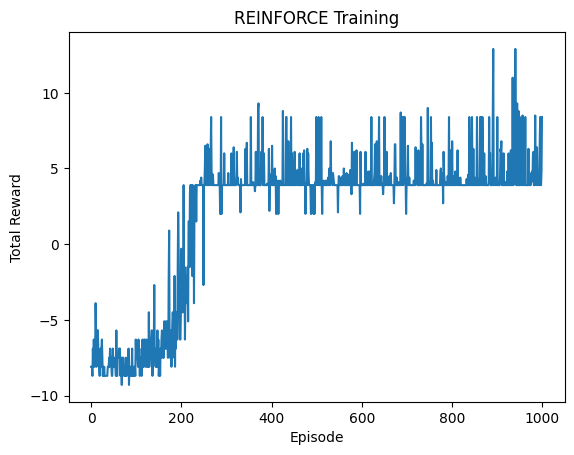

In [6]:
env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=False)
train(env)

## Let bot play the game

In [35]:
env = gym.make("FlappyBird-v0", render_mode="human", use_lidar=False)

# Load model before testing or resuming training
policy_net = Policy_Network(state_dim=12, action_dim=2)
policy_net.load_state_dict(torch.load("saved_policies/policy_net.pth"))
policy_net.eval()

# Use the trained model
obs, _ = env.reset()
done = False
while not done:

    action, log_prob = choose_action(policy_net, obs)

    obs, reward, done, truncated, info = env.step(action)
    # print(f"Action {action} gave {reward} reward...")
    # print(obs, reward, done, truncated, info)

env.close()


In [6]:
import numpy as np

env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=False)

policy_net = Policy_Network(state_dim=12, action_dim=2)
policy_net.load_state_dict(torch.load("saved_policies/policy_net.pth"))
policy_net.eval()

num_episodes = 1000
episode_rewards = []

for ep in range(num_episodes):
    print(ep)
    obs, _ = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        action, log_prob = choose_action(policy_net, obs)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward

    episode_rewards.append(total_reward)

mean_reward = np.mean(episode_rewards)
variance_reward = np.var(episode_rewards)

print(f"Over {num_episodes} episodes:")
print(f"Mean Reward: {mean_reward}")
print(f"Reward Variance: {variance_reward}")

env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27